<a href="https://colab.research.google.com/github/souken-b/calc_OWC/blob/main/cal_pulsating_pres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1003]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

In [1004]:
T = 3 # 周期
n = 100 # 分割数
#############
# n_diam = 0.008123 # オリフィス直径(m)
# D0 = 0.0254 # 円管の直径(m)
# A = 5.1823028331816915 * 1e-05 # オリフィスの断面積(m2)
# A0 = np.pi * ((D0 / 2) ** 2) # 円管の断面積(m2)
# L0 = 0.12 # t=0での空気室高さ(m)
# # L0 = 0.15830000000000002 # ピストンロッドの長さ(m)
# L = 0.08 # ピストン変位振幅(m)
# d_ratio = n_diam / D0 # 絞り直径比
# n_ratio = d_ratio ** 2 # 絞り面積比
##############
n_diam = 0.035 # オリフィス直径(m)
D0 = 0.5 # 円管の直径(m)
A = 0.00096211275 # オリフィスの断面積(m2)
A0 = 0.19242255 # 円管の断面積(m2)
L0 = 0.625 # t=0での空気室高さ(m)
L = 0.06066 # ピストン変位振幅(m)
d_ratio = n_diam / D0 # 絞り直径比
n_ratio = d_ratio ** 2 # 絞り面積比
###############
h_ratio = 1.4 # 比熱比
p_air = 101325 # 大気圧(pa)
dens_air = 1.225 # 空気の密度(kg/m3)
p_0 = p_air + 10 # 圧力の初期値

In [1005]:
def c_ci(d_ratio)->'非圧縮性の縮流係数':
  # flow coefficient
  f_coef = 0.598 - 0.003 * (d_ratio ** 2) + 0.404 * (d_ratio ** 4)
  return (f_coef / ((1 + (d_ratio ** 4) * (f_coef ** 2)) ** (1/2)))

In [1006]:
def force_ci(c_ci)->'非圧縮性力欠損係数':
  return ((1 / c_ci) - (1 / (2 * (c_ci ** 2))))

In [1007]:
def c_c(f_ci_c, p_up, p_down, h_ratio)->'圧縮性の縮流係数':
  p_ratio = p_up / p_down
  h_ratio_rev = 1/ h_ratio
  return ((1 / (2 * f_ci_c)) * (p_ratio ** h_ratio_rev) * (1 - (1 - ((2 * f_ci_c * (1 - h_ratio_rev)) * (1 - (1 / p_ratio)) / (1- (p_ratio) ** (h_ratio_rev - 1))))  ** (1/2)))

In [1008]:
def runge_kutta(t_interval, t_list, c_freq, p_list, V0_list, dV0dt_list, p_air, dens_air, T, d_ratio, h_ratio, A0, L, L0, A, f_ci_c):
  t = t_list
  p = p_list
  V0 = V0_list
  dV0dt = dV0dt_list
  h = t_interval


  # 方程式を解くための反復計算
  for i in range(len(t) -1):
    const_args = [p_air, dens_air, T, d_ratio, h_ratio, V0[i], dV0dt[i], A, f_ci_c]
    k_1 = h * dpdt(p[i], t[i], *const_args)
    k_2 = h * dpdt(p[i] + k_1 / 2 , t[i] + h/2, *const_args)
    k_3 = h * dpdt(p[i] + k_2 / 2 , t[i] + h/2, *const_args)
    k_4 = h * dpdt(p[i] + k_3, t[i] + h, *const_args)
    p[i+1] = p[i] + 1/6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)
    if (np.isnan(p[i+1])):
      break
    V0[i+1] =  (L0 + L*np.cos(c_freq * t[i])) * A0
    dV0dt[i+1] = ((-1) * c_freq * L * np.sin(c_freq * t[i])) * A0
  return t, p, V0

In [1009]:
def func_dydt(y , t):
  dydt = -y
  return dydt

In [1010]:
def calc_pressure(n, T, p_0, p_air, dens_air, d_ratio, h_ratio, A0, L, L0, A, f_ci_c):
  h = T / n
  t = np.arange(0, 4*T, h)
  p = np.empty(len(t))
  p[0] = p_0
  V0 = np.empty(len(t))
  dV0dt = np.empty(len(t))
  V0[0] = (L0 + L)*A0
  dV0dt[0] = 0

  c_freq = 2 * np.pi / T
  t, p, V0 = runge_kutta(h, t, c_freq, p, V0, dV0dt, p_air, dens_air, T, d_ratio, h_ratio, A0, L, L0, A, f_ci_c)
  
  return t, p, V0

In [1011]:
def forward_flow(c_c_c, A, p_up, p_air, h_ratio, dens_up, dens_air):
  h_ratio_rev = 1 / h_ratio
  return  (dens_up / dens_air) * (c_c_c * A  * ((p_up / p_air) ** (-1 * h_ratio_rev)) * (((2 / (1 - h_ratio_rev)) * (p_up / dens_up) * (1 - (p_up / p_air) ** (h_ratio_rev - 1))) ** (1 / 2)))

In [1012]:
def back_flow(c_c_c, A, p_air, p_down, h_ratio, dens_air):
  h_ratio_rev = 1 / h_ratio
  return  c_c_c * A  * ((p_air / p_down) ** (-1 * h_ratio_rev)) * (((2 / (1 - h_ratio_rev)) * (p_air / dens_air) * (1 - (p_air / p_down) ** (h_ratio_rev - 1))) ** (1 / 2))

In [1013]:
def dpdt(p0, t, p_air, dens_air, T, d_ratio, h_ratio, V0, dV0dt, A, f_ci_c)->'押出圧力変化':
  # 円振動数ω
  c_freq = 2 * np.pi / T
  h_ratio_rev = 1 / h_ratio
  if (p0 > p_air):
    # 上流密度
    dens0 = dens_air * ((p0 / p_air) ** (h_ratio_rev))
    c_c_c = c_c(f_ci_c, p0, p_air, h_ratio)
    flow = forward_flow(c_c_c, A, p0, p_air, dens_air, h_ratio, dens0)
    dpdt = (-7/5) * p0 * ((dV0dt / V0) + ((dens_air / dens0) * (flow / V0)))
  else:
    dens0 = dens_air * ((p0 / p_air) ** (h_ratio_rev))
    c_c_c = c_c(f_ci_c, p_air, p0, h_ratio)
    flow = back_flow(c_c_c, A, p_air, p0, h_ratio, dens_air)
    dpdt = (-7/5) * p0 * ((dV0dt / V0) + (((dens_air / dens0) ** h_ratio) * (((-1) * flow) / V0)))
  return dpdt

In [1014]:
c_ci_c = c_ci(d_ratio)
f_ci_c = force_ci(c_ci_c)
result = calc_pressure(n, T, p_0, p_air, dens_air, d_ratio, h_ratio, A0, L, L0, A, f_ci_c)
t_list, p_list, v0_list = result

In [1015]:
p_air_list = [101375] * len(p_list)
p_list_diff = p_list - p_air_list

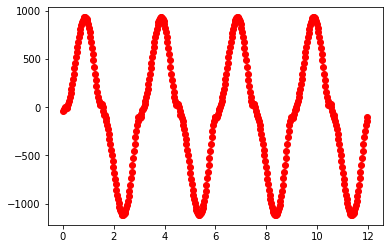

In [1016]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# ax.scatter(t_list, p_list, c='blue')
# ax.scatter(t_list, p_air_list, c='green')
ax.scatter(t_list, p_list_diff, c='red')
plt.show()

In [1017]:
(v0_list.max() - v0_list.min())/2

0.011672351883000004

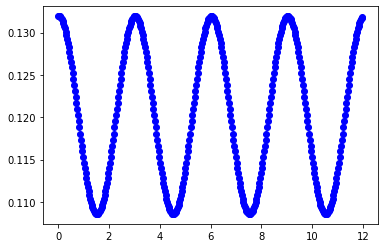

In [1018]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
ax2.scatter(t_list, v0_list, c='blue')
plt.show()